In [1]:
import io
import re
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from collections import Counter, defaultdict
import spacy
from sklearn.model_selection import train_test_split
from nltk.tokenize.treebank import TreebankWordDetokenizer as Detok
from nltk.translate.bleu_score import corpus_bleu

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import Input, layers
from keras.activations import softmax
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback
from keras import backend as K

import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()

Using TensorFlow backend.


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [3]:
data_path = '../data'
model_path = '../model'

In [51]:
!ls ../data/fra-eng

_about.txt  fra.txt


In [4]:
# Translation data
# http://www.manythings.org/anki/
with io.open(os.path.join(data_path, 'fra-eng/fra.txt'), encoding='utf-8') as f:
    lines = f.read().split('\n')

pairs = [l.split('\t') for l in lines if l != '']
pairs = [[re.sub(u"\u202f|\u2009", " ", s) for s in p] for p in pairs]

In [5]:
X, y = np.array(pairs)[:, 0], np.array(pairs)[:, 1]
len(X), len(y)

(154883, 154883)

In [6]:
zip(X, y)[:5]

[(u'Go.', u'Va !'),
 (u'Run!', u'Cours !'),
 (u'Run!', u'Courez !'),
 (u'Fire!', u'Au feu !'),
 (u'Help!', u"\xc0 l'aide !")]

# Extract features

In [7]:
# Tokenize
spacy_tokenizer = spacy.load('xx')

In [8]:
def tokenize(msg):
    return [tok.text for tok in spacy_tokenizer.tokenizer(unicode(msg.lower()))]

X = Parallel(n_jobs=num_cores)(delayed(tokenize)(msg) for msg in X)
y = Parallel(n_jobs=num_cores)(delayed(tokenize)(msg) for msg in y)

len(X), len(y)

(154883, 154883)

In [9]:
zip(X, y)[:5]

[([u'go', u'.'], [u'va', u'!']),
 ([u'run', u'!'], [u'cours', u'!']),
 ([u'run', u'!'], [u'courez', u'!']),
 ([u'fire', u'!'], [u'au', u'feu', u'!']),
 ([u'help', u'!'], [u'\xe0', u"l'aide", u'!'])]

In [10]:
# For ease of training, only keep sentences shorter than 20 words
X_len = [len(msg) for msg in X]
y_len = [len(msg) for msg in y]

min_len = 2
max_len = 20

X_to_keep_ix = np.where((np.array(X_len) >= min_len) & (np.array(X_len) <= max_len))[0]
y_to_keep_ix = np.where((np.array(y_len) >= min_len) & (np.array(y_len) <= max_len))[0]

to_keep_ix = np.intersect1d(X_to_keep_ix, y_to_keep_ix)
len(to_keep_ix)

154326

In [11]:
X = np.array(X)[to_keep_ix]
y = np.array(y)[to_keep_ix]

len(X), len(y)

(154326, 154326)

In [12]:
# Split into training and validation sets
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=.2, random_state=0)
len(X_trn), len(X_val), len(y_trn), len(y_val)

(123460, 30866, 123460, 30866)

In [13]:
# Create mappers (using training data)
X_toks_trn = list(itertools.chain(*X_trn))
y_toks_trn = list(itertools.chain(*y_trn))

len(X_toks_trn), len(y_toks_trn)

(929627, 982087)

In [14]:
UNK = '_unk_'
PAD = '_pad_'

def create_mapper(toks, max_vocab=100000, min_freq=1, UNK=UNK, PAD=PAD):
    """Create mappers between tokens and numerical indices.

    Parameters
    ----------
    toks : A list containing all raw tokens (before deduping).

    max_vocab : The maximum vocabulary size.

    min_freq : The minimum frequency for a token to be included in the vocabulary.

    UNK : Special token for unknown word (default to '_unk_').

    PAD : Special token for paddings (default to '_pad_').

    Returns
    -------
    stoi : A dictionary that maps tokens to indices.

    itos : A list that maps indices to tokens.
    """
    
    toks_freq = Counter(toks)
    
    itos = [s for s, c in toks_freq.most_common(max_vocab) if c >= min_freq]
    
    if PAD:
        if UNK:
            itos.insert(0, UNK)
            itos.insert(0, PAD)  # Note the index for UNK is 1 and the index for PAD is 0

            stoi = defaultdict(lambda: 1, {v: k for k, v in enumerate(itos)})
        else:
            itos.insert(0, PAD)  # Note the index for PAD is 0
            stoi = {v: k for k, v in enumerate(itos)}
    else:
        if UNK:
            itos.insert(0, UNK)  # Note the index for UNK is 0
            stoi = defaultdict(lambda: 0, {v: k for k, v in enumerate(itos)})
        else:
            stoi = {v: k for k, v in enumerate(itos)}
    
    return stoi, itos

In [15]:
X_stoi, X_itos = create_mapper(X_toks_trn)
y_stoi, y_itos = create_mapper(y_toks_trn)

len(X_itos), len(y_itos)

(12637, 23952)

In [16]:
X_itos[:10]

['_pad_', '_unk_', u'.', u'i', u'you', u'to', u'the', u'?', u'a', u"n't"]

In [17]:
y_itos[:10]

['_pad_', '_unk_', u'.', u'je', u'de', u'-', u'?', u'pas', u'vous', u'que']

In [18]:
# Add GO (only needed for the target mappers)
GO = '_go_'

y_stoi[GO] = len(y_stoi)
y_itos.append(GO)

In [19]:
# Encode text features
def encode_msg(toks, stoi, max_len, padding_pos='post', truncating='pre', padding_token=PAD):
    # Index
    toks_id = [[stoi[tok] for tok in msg] for msg in toks]
    
    # Pad
    toks_id_pad = pad_sequences(toks_id, max_len, padding=padding_pos, truncating=truncating, value=stoi[padding_token])
    
    return toks_id_pad

In [20]:
X_ix_trn = encode_msg(X_trn, X_stoi, max_len)
y_ix_trn = encode_msg(y_trn, y_stoi, max_len)
X_ix_val = encode_msg(X_val, X_stoi, max_len)
y_ix_val = encode_msg(y_val, y_stoi, max_len)

X_ix_trn.shape, y_ix_trn.shape, X_ix_val.shape, y_ix_val.shape

((123460, 20), (123460, 20), (30866, 20), (30866, 20))

In [21]:
# Sanity check
np.array(X_itos)[X_ix_trn[0]], np.array(y_itos)[y_ix_trn[0]]

(array([u'here', u'is', u'a', u'brief', u'description', u'.', u'_pad_',
        u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_',
        u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_',
        u'_pad_'], dtype='<U17'),
 array([u'voici', u'une', u'br\xe8ve', u'description', u'.', u'_pad_',
        u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_',
        u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_',
        u'_pad_', u'_pad_'], dtype='<U19'))

In [22]:
np.array(X_itos)[X_ix_val[0]], np.array(y_itos)[y_ix_val[0]]

(array([u'tom', u'said', u'my', u'plan', u'would', u"n't", u'work', u'.',
        u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_',
        u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_'],
       dtype='<U17'),
 array([u'tom', u'a', u'dit', u'que', u'mon', u'plan', u'ne',
        u'fonctionnera', u'pas', u'.', u'_pad_', u'_pad_', u'_pad_',
        u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_', u'_pad_',
        u'_pad_'], dtype='<U19'))

# Create models

In [23]:
K.clear_session()

## Encoder

In [24]:
# Define hidden size
hidden_size_enc = 256
hidden_size_dec = 256

In [25]:
# Define layers
txt_embed_size = 256

X_embed_layer = layers.Embedding(input_dim=len(X_itos), output_dim=txt_embed_size, name='X_embed_layer')
lstm_enc = layers.LSTM(hidden_size_enc, return_sequences=True, return_state=True, name='lstm_enc')

In [26]:
# Input tensor
X = Input(shape=(max_len, ), name='X')

In [27]:
# Encode
def encode(X):
    X_emb = X_embed_layer(X)
    a_enc, h_enc, c_enc = lstm_enc(X_emb)
    return a_enc, h_enc, c_enc

## Decoder without attention

### Decoder

In [28]:
# Define layers
y_embed_layer = layers.Embedding(input_dim=len(y_itos), output_dim=txt_embed_size, name='y_embed_layer')
lstm_dec_wo_attn = layers.LSTM(hidden_size_dec, return_sequences=True, return_state=True, name='lstm_dec_wo_attn')
densor_dec = layers.Dense(len(y_itos), activation='softmax', name='densor_dec')

In [29]:
# Decoder input used in training (i.e., "GO" + `y` shifted by 1)
in_dec = Input(shape=(max_len, ), name='in_dec')

In [30]:
def decode_wo_attn(in_dec, h_enc, c_enc):
    in_dec_emb = y_embed_layer(in_dec)
    
    # Feed into decoder LSTM
    a_dec, h_dec, c_dec = lstm_dec_wo_attn(in_dec_emb, initial_state=[h_enc, c_enc])
    
    # Feed the output into a dense layer with softmax
    out_dec = densor_dec(a_dec)
    return out_dec, h_dec, c_dec

### Put together

In [31]:
# Encode
a_enc, h_enc, c_enc = encode(X)

In [32]:
# Decode
out_dec, _, _ = decode_wo_attn(in_dec, h_enc, c_enc)

In [33]:
# Put together
model_wo_attn = Model(inputs=[X, in_dec], outputs=out_dec)
model_wo_attn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 20)           0                                            
__________________________________________________________________________________________________
in_dec (InputLayer)             (None, 20)           0                                            
__________________________________________________________________________________________________
X_embed_layer (Embedding)       (None, 20, 256)      3235072     X[0][0]                          
__________________________________________________________________________________________________
y_embed_layer (Embedding)       (None, 20, 256)      6131968     in_dec[0][0]                     
__________________________________________________________________________________________________
lstm_enc (

In [34]:
model_wo_attn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

## Decoder with attention

### Attention layer

In [49]:
# Define layers
in_dec_embed_flattener = layers.Flatten(name='in_dec_embed_flattener')  # Needed because embedding output has an exrta dimension in the middle
attn_repeator = layers.RepeatVector(max_len, name='attn_repeator')
attn_concatenator = layers.Concatenate(name='attn_concatenator')
attn_weights_computer = layers.Dense(1, activation='tanh', name='attn_weights_computer')

def softmax_axis_1(x):
    return softmax(x, axis=1)
attn_weights_normalizer = layers.Activation(softmax_axis_1, name='attn_weights_normalizer')

attn_context_computer = layers.Dot(axes=1, name='attn_context_computer')

In [50]:
def one_step_attn(a_enc, in_dec_embed):
    # Repeat `in_dec_embed`
    in_dec_embed = in_dec_embed_flattener(in_dec_embed)  # (None, txt_embed_size)
    in_dec_embed = attn_repeator(in_dec_embed)  # (None, timesteps, txt_embed_size)
    
    # Compute the attention weights
    in_dec_w_a_enc = attn_concatenator([in_dec_embed, a_enc])  # (None, timesteps, txt_embed_size + hidden_size)
    attn_weights = attn_weights_computer(in_dec_w_a_enc)  # (None, timesteps, 1)
    
    # Normalize all the weights using a softmax (the normalization is applied in the timestep's axis)
    attn_weights_norm = attn_weights_normalizer(attn_weights)  # (None, timesteps, 1)
    
    # Use the normalized weights to compute the weighted-average encoder outputs (i.e., the context)
    attn_context = attn_context_computer([attn_weights_norm, a_enc])  # (None, 1, hidden_size_dec)
    
    return attn_context, attn_weights_norm

### Decoder

In [51]:
y_embed_layer = layers.Embedding(input_dim=len(y_itos), output_dim=txt_embed_size, name='y_embed_layer')
context_input_concatenator = layers.Concatenate(name='context_input_concatenator')
densor_dec_0 = layers.Dense(hidden_size_dec, name='densor_dec_0')
lstm_dec_w_attn = layers.LSTM(hidden_size_dec, return_sequences=False, return_state=True, name='lstm_dec_w_attn')
densor_dec_1 = layers.Dense(len(y_itos), activation='softmax', name='densor_dec_1')

In [52]:
# One-step decoder
def decode_w_attn(in_dec, a_enc, h_dec_prev, c_dec_prev):
    # Embed current decoder input
    in_dec_embed = y_embed_layer(in_dec)
    
    # Compute context vector using the attention layer
    attn_context, attn_weights_norm = one_step_attn(a_enc, in_dec_embed)
    
    # Concatenate with the decoder input
    attn_context_w_input = context_input_concatenator([attn_context, in_dec_embed])
    
    # Reduce dimension to the original hidden size
    attn_context_w_input = densor_dec_0(attn_context_w_input)
    
    # Feed into decoder LSTM
    a_dec, h_dec, c_dec = lstm_dec_w_attn(attn_context_w_input, initial_state=[h_dec_prev, c_dec_prev])
    
    # Feed the output into a dense layer with softmax
    out_dec = densor_dec_1(a_dec)
    return out_dec, h_dec, c_dec, attn_weights_norm

###  Put together

In [53]:
# Encode
a_enc, h_enc, c_enc = encode(X)

In [54]:
# Decode
in_dec_0 = Input(shape=(1, ), name='in_dec_0')  # Decoder starting token ("_go_")
y = Input(shape=(max_len, ), name='y')
y_slicer = layers.Lambda(lambda x: x[:, i:i+1], name='y_slicer')

h_dec_prev, c_dec_prev = h_enc, c_enc
in_dec = in_dec_0
outs_dec = []

for i in range(max_len):
    out_dec, h_dec, c_dec, _ = decode_w_attn(in_dec, a_enc, h_dec_prev, c_dec_prev)
    outs_dec.append(out_dec)
    h_dec_prev, c_dec_prev = h_dec, c_dec
    in_dec = y_slicer(y)

In [55]:
# Put together
model_w_attn = Model(inputs=[X, in_dec_0, y], outputs=outs_dec)
model_w_attn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_dec_0 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
y (InputLayer)                  (None, 20)           0                                            
__________________________________________________________________________________________________
y_embed_layer (Embedding)       (None, 1, 256)       6131968     in_dec_0[0][0]                   
                                                                 y_slicer[0][0]                   
                                                                 y_slicer[1][0]                   
                                                                 y_slicer[2][0]                   
          

In [56]:
model_w_attn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# Train models

## Model without attention

In [35]:
# Initialize decoder input
in_dec_trn = np.hstack([np.array([y_stoi[GO]] * len(X_ix_trn)).reshape(-1, 1), y_ix_trn[:, :-1]])
in_dec_val = np.hstack([np.array([y_stoi[GO]] * len(X_ix_val)).reshape(-1, 1), y_ix_val[:, :-1]])

in_dec_trn.shape, in_dec_val.shape

((123460, 20), (30866, 20))

In [36]:
# Reshape outputs in order to use `sparse_categorical_crossentropy`
y_ix_trn_rs = y_ix_trn.reshape(y_ix_trn.shape[0], y_ix_trn.shape[1], 1)
y_ix_val_rs = y_ix_val.reshape(y_ix_val.shape[0], y_ix_val.shape[1], 1)

y_ix_trn_rs.shape, y_ix_val_rs.shape

((123460, 20, 1), (30866, 20, 1))

In [37]:
# Add callbacks
callbacks = []

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
callbacks.append(reduce_lr)

stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks.append(stopper)

checkpoint = ModelCheckpoint(filepath=os.path.join(model_path, 'translate-keras-wo_attn.h5'), monitor='val_loss', save_best_only=True, verbose=1)
callbacks.append(checkpoint)

In [ ]:
# Train
hist_wo_attn = model_wo_attn.fit(
    x=[X_ix_trn, in_dec_trn],
    y=y_ix_trn_rs,
    batch_size=64,
    epochs=20,
    validation_data=([X_ix_val, in_dec_val], y_ix_val_rs),
    callbacks=callbacks)

In [39]:
def plot_losses(model_hist):
    loss = pd.DataFrame(zip(model_hist.history['loss'], model_hist.history['val_loss']), columns=['loss', 'val_loss'])
    
    # Find the epoch with the smallest loss
    min_loss_ix = np.array(model_hist.history['val_loss']).argmin()

    # Plot
    ax = loss.plot()
    ax.axvline(x=min_loss_ix, color='black', ls='--')

    return loss

,loss,val_loss
0,2.060479,1.518045
1,1.278625,1.149528
2,0.960211,0.955534
3,0.750122,0.841058
4,0.601100,0.770340
5,0.492800,0.733297
6,0.412307,0.711273
7,0.351961,0.702395
8,0.305549,0.700130
9,0.269756,0.702282


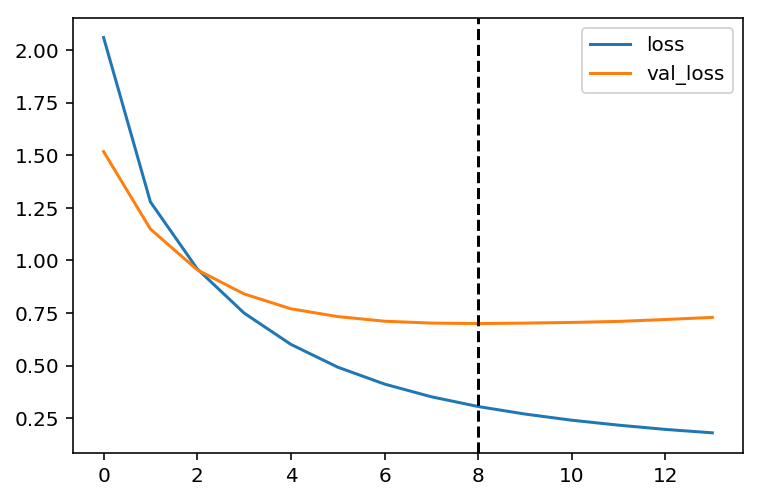

In [40]:
plot_losses(hist_wo_attn)

## Model with attention

In [57]:
# Initialize decoder input ("_go_")
in_dec_0_trn = np.array([y_stoi[GO]] * len(X_ix_trn)).reshape(-1, 1)
in_dec_0_val = np.array([y_stoi[GO]] * len(X_ix_val)).reshape(-1, 1)

in_dec_0_trn.shape, in_dec_0_val.shape

((123460, 1), (30866, 1))

In [61]:
# Reshape outputs in order to use `sparse_categorical_crossentropy`
y_ix_trn_rs = [y_ix_trn[:, i:i+1] for i in range(y_ix_trn.shape[1])]
y_ix_val_rs = [y_ix_val[:, i:i+1] for i in range(y_ix_val.shape[1])]

np.array(y_ix_trn_rs).shape, np.array(y_ix_val_rs).shape

((20, 123460, 1), (20, 30866, 1))

In [62]:
# Add callbacks
callbacks = []

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
callbacks.append(reduce_lr)

stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks.append(stopper)

checkpoint = ModelCheckpoint(filepath=os.path.join(model_path, 'translate-keras-w_attn.h5'), monitor='val_loss', save_best_only=True, verbose=1)
callbacks.append(checkpoint)

In [ ]:
# Train
hist_w_attn = model_w_attn.fit(
    x=[X_ix_trn, in_dec_0_trn, y_ix_trn],
    y=y_ix_trn_rs,
    batch_size=64,
    epochs=20,
    validation_data=([X_ix_val, in_dec_0_val, y_ix_val], y_ix_val_rs),
    callbacks=callbacks)

,loss,val_loss
0,42.564779,31.746300
1,27.670609,25.786471
2,22.338587,22.338957
3,18.479439,19.904866
4,15.406875,18.125841
5,12.954165,16.888505
6,11.022862,16.079986
7,9.514409,15.602190
8,8.336455,15.241515
9,7.394344,15.103382


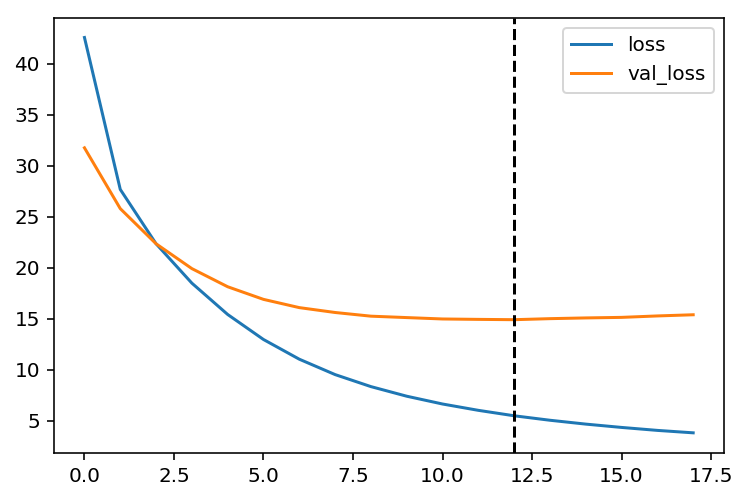

In [65]:
plot_losses(hist_w_attn)

# Inference

## Model without attention

In [41]:
# Reload the last checkpoint
model_wo_attn = load_model(os.path.join(model_path, 'translate-keras-wo_attn.h5'))

In [42]:
# Extract encoder
X = Input(shape=(max_len, ), name='X')
X_embed_layer = model_wo_attn.get_layer('X_embed_layer')
lstm_enc = model_wo_attn.get_layer('lstm_enc')

encoder = Model(X, encode(X))
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 20)                0         
_________________________________________________________________
X_embed_layer (Embedding)    (None, 20, 256)           3235072   
_________________________________________________________________
lstm_enc (LSTM)              [(None, 20, 256), (None,  525312    
Total params: 3,760,384
Trainable params: 3,760,384
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Extract decoder
in_dec = Input(shape=(1, ), name='in_dec')
h_dec_prev = Input(shape=(hidden_size_dec, ), name='h_dec_prev')
c_dec_prev = Input(shape=(hidden_size_dec, ), name='c_dec_prev')
y_embed_layer = model_wo_attn.get_layer('y_embed_layer')
lstm_dec_wo_attn = model_wo_attn.get_layer('lstm_dec_wo_attn')
densor_dec = model_wo_attn.get_layer('densor_dec')

decoder = Model([in_dec, h_dec_prev, c_dec_prev], decode_wo_attn(in_dec, h_dec_prev, c_dec_prev))
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_dec (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
y_embed_layer (Embedding)       multiple             6131968     in_dec[0][0]                     
__________________________________________________________________________________________________
h_dec_prev (InputLayer)         (None, 256)          0                                            
__________________________________________________________________________________________________
c_dec_prev (InputLayer)         (None, 256)          0                                            
__________________________________________________________________________________________________
lstm_dec_w

In [46]:
def decode_sequence(input_seqs, encoder, decoder, toks_stoi, toks_itos, max_len, w_attn=False, return_attn_weights=False):
    # Generate encoder output
    a_enc_pred, h_enc_pred, c_enc_pred = encoder.predict(input_seqs)

    # Generate decoder output, one timestep at a time
    outs_dec_pred = []
    attn_weights = []
    in_dec = np.array([toks_stoi[GO]] * len(input_seqs)).reshape(-1, 1)
    h_dec_pred = h_enc_pred
    c_dec_pred = c_enc_pred

    for i in range(max_len):
        if not w_attn:
            out_dec_pred, h_dec_pred, c_dec_pred = decoder.predict([in_dec, h_dec_pred, c_dec_pred])
        else:
            out_dec_pred, h_dec_pred, c_dec_pred, attn_weight = decoder.predict([in_dec, a_enc_pred, h_dec_pred, c_dec_pred])

        # Derive the predicted token
        # Need to first reduce the dimension of `out_dec_pred` from 3D to 2D
        # (It's 3D because there is a `timestep` of 1 in the middle)
        out_dec_pred = out_dec_pred.reshape(out_dec_pred.shape[0], out_dec_pred.shape[-1])
        out_dec_pred = out_dec_pred.argmax(axis=-1)
        outs_dec_pred.append(out_dec_pred)

        # Assign the predicted token as the next decoder input
        in_dec = out_dec_pred
        
        # Save attention weights
        if w_attn:
            attn_weights.append(attn_weight.reshape(attn_weight.shape[0], attn_weight.shape[1]))

    # Convert output index into tokens
    outs_dec_pred = np.array(toks_itos)[np.array(outs_dec_pred).transpose()]
    
    # Clean up and output
    outs_dec_pred = [detok(toks) for toks in outs_dec_pred]
    if not return_attn_weights:
        return outs_dec_pred
    return outs_dec_pred, attn_weights

# Convert to strings and clean up
# detokenizer = Detok()

def detok(toks):
    # Cut before the first padding (if any)
    toks = list(toks)
    if PAD in toks:
        first_pad = toks.index(PAD)
        toks = toks[:first_pad]
    
    # return detokenizer.detokenize(toks)
    return ' '.join(toks)

In [47]:
# Test inference with validation data
y_val_pred_wo_attn = decode_sequence(X_ix_val, encoder, decoder, y_stoi, y_itos, max_len)
len(y_val_pred_wo_attn)

30866

In [48]:
# Print out a few results
for i in range(5):
    print(i)
    print('Input:\t\t' + detok(X_val[i]))
    print('Predicted:\t' + y_val_pred_wo_attn[i])
    print('True:\t\t' + detok(y_val[i]))

0
Input:		tom said my plan would n't work .
Predicted:	tom a dit que mon plan n'était pas crédible .
True:		tom a dit que mon plan ne fonctionnera pas .
1
Input:		a watered down compromise resolution is better than none at all .
Predicted:	un navire qui a fait beaucoup de fautes ne plus en détail .
True:		une résolution sur un compromis restreint est préférable à rien du tout .
2
Input:		could i get one more beer , please ?
Predicted:	pourrais - je avoir une bière , s'il te plaît ?
True:		pourrais - je avoir une bière supplémentaire , je vous prie ?
3
Input:		i want to ask you one simple question .
Predicted:	je veux vous demander une autre question .
True:		je veux te poser une simple question .
4
Input:		i ca n't stand to see animals be teased .
Predicted:	je ne peux pas supporter les voir en forme que les femmes .
True:		je ne supporte pas de voir des animaux être taquinés .


## Model with attention

In [67]:
# Reload the last checkpoint
model_w_attn = load_model(os.path.join(model_path, 'translate-keras-w_attn.h5'), custom_objects={'softmax_axis_1': softmax_axis_1, 'i': 0})

In [68]:
# Extract encoder
X = Input(shape=(max_len, ), name='X')
X_embed_layer = model_w_attn.get_layer('X_embed_layer')
lstm_enc = model_w_attn.get_layer('lstm_enc')

encoder = Model(X, encode(X))
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 20)                0         
_________________________________________________________________
X_embed_layer (Embedding)    (None, 20, 256)           3235072   
_________________________________________________________________
lstm_enc (LSTM)              [(None, 20, 256), (None,  525312    
Total params: 3,760,384
Trainable params: 3,760,384
Non-trainable params: 0
_________________________________________________________________


In [70]:
# Extract decoder
in_dec = Input(shape=(1, ), name='in_dec')
a_enc = Input(shape=(max_len, hidden_size_enc), name='a_enc')
h_dec_prev = Input(shape=(hidden_size_dec, ), name='h_dec_prev')
c_dec_prev = Input(shape=(hidden_size_dec, ), name='c_dec_prev')

y_embed_layer = model_w_attn.get_layer('y_embed_layer')
in_dec_embed_flattener = model_w_attn.get_layer('in_dec_embed_flattener')
attn_repeator = model_w_attn.get_layer('attn_repeator')
attn_concatenator = model_w_attn.get_layer('attn_concatenator')
attn_weights_computer = model_w_attn.get_layer('attn_weights_computer')
attn_weights_normalizer = model_w_attn.get_layer('attn_weights_normalizer')
attn_context_computer = model_w_attn.get_layer('attn_context_computer')
context_input_concatenator = model_w_attn.get_layer('context_input_concatenator')
densor_dec_0 = model_w_attn.get_layer('densor_dec_0')
lstm_dec_w_attn = model_w_attn.get_layer('lstm_dec_w_attn')
densor_dec_1 = model_w_attn.get_layer('densor_dec_1')

decoder = Model([in_dec, a_enc, h_dec_prev, c_dec_prev], decode_w_attn(in_dec, a_enc, h_dec_prev, c_dec_prev))
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_dec (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
y_embed_layer (Embedding)       (None, 1, 256)       6131968     in_dec[0][0]                     
__________________________________________________________________________________________________
in_dec_embed_flattener (Flatten (None, 256)          0           y_embed_layer[20][0]             
__________________________________________________________________________________________________
attn_repeator (RepeatVector)    (None, 20, 256)      0           in_dec_embed_flattener[20][0]    
__________________________________________________________________________________________________
a_enc (Inp

In [71]:
# Test inference with validation data
y_val_pred_w_attn, y_val_attn_weights = decode_sequence(X_ix_val, encoder, decoder, y_stoi, y_itos, max_len, w_attn=True, return_attn_weights=True)
len(y_val_pred_w_attn)

30866

In [72]:
# Print out a few results
for i in range(5):
    print(i)
    print('Input:\t\t' + detok(X_val[i]))
    print('Predicted:\t' + y_val_pred_w_attn[i])
    print('True:\t\t' + detok(y_val[i]))

0
Input:		tom said my plan would n't work .
Predicted:	tom a dit que mon projet n'était pas prêt .
True:		tom a dit que mon plan ne fonctionnera pas .
1
Input:		a watered down compromise resolution is better than none at all .
Predicted:	un certain qu'elle a encore des problèmes sans climatisation .
True:		une résolution sur un compromis restreint est préférable à rien du tout .
2
Input:		could i get one more beer , please ?
Predicted:	pourrais - je avoir une bière supplémentaire , s'il vous plaît ?
True:		pourrais - je avoir une bière supplémentaire , je vous prie ?
3
Input:		i want to ask you one simple question .
Predicted:	je veux vous poser une question très simple .
True:		je veux te poser une simple question .
4
Input:		i ca n't stand to see animals be teased .
Predicted:	je ne supporte pas d'être traité de vos talents .
True:		je ne supporte pas de voir des animaux être taquinés .


## Compute BLEU scores

In [49]:
# Compute corpus-level BLEU score
def compute_corpus_bleu(references, candidates):
    # BLEU-1
    bleu_1 = corpus_bleu(references, candidates, weights=(1, 0, 0, 0))
    
    # BLEU-2
    bleu_2 = corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0))
    
    # BLEU-3
    bleu_3 = corpus_bleu(references, candidates, weights=(0.33, 0.33, 0.33, 0))
    
    # BLEU-4
    bleu_4 = corpus_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_1, bleu_2, bleu_3, bleu_4

In [50]:
# Without attention
compute_corpus_bleu([[detok(ref)] for ref in y_val], y_val_pred_wo_attn)

(0.8096384279217266, 0.723528741126314, 0.6599570189798332, 0.6084379064362584)

In [74]:
# With attention
compute_corpus_bleu([[detok(ref)] for ref in y_val], y_val_pred_w_attn)

(0.8027370540494299,
 0.7149344505191387,
 0.6508398311666369,
 0.5993017398019028)

## Visualize attention weights

In [120]:
i = 6
X_val[i], y_val[i], y_val_pred_w_attn[i]

([u'security', u'was', u'increased', u'in', u'the', u'city', u'.'],
 [u"c'est",
  u'la',
  u's\xe9curit\xe9',
  u'qui',
  u'a',
  u'\xe9t\xe9',
  u'renforc\xe9e',
  u'dans',
  u'la',
  u'ville',
  u'.'],
 u'la situation est pass\xe9e en ville .')

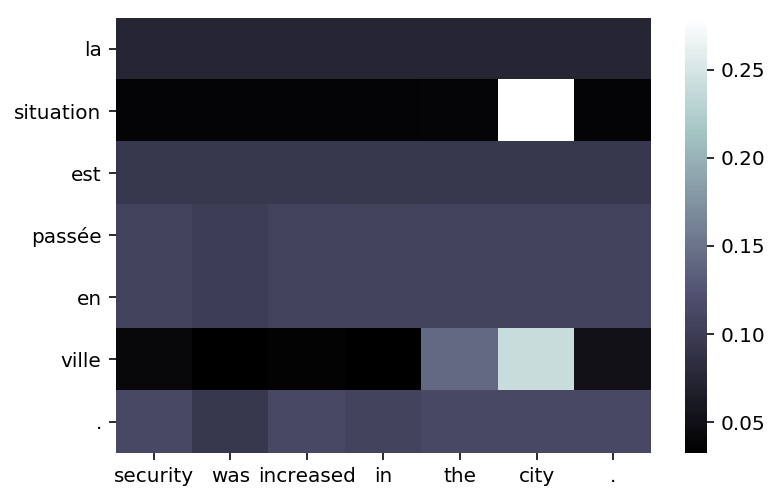

In [121]:
attn_weights_df = pd.DataFrame(np.array([a[i] for a in y_val_attn_weights])[:len(y_val_pred_w_attn[i].split()), :len(X_val[i])], columns=X_val[i], index=y_val_pred_w_attn[i].split())
sns.heatmap(attn_weights_df, cmap='bone')